In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from dataretrieval import nwis

In [ ]:
def cumulative_exceedence_pct(val: np.float64, series: pd.Series) -> np.float64:
  m = series > val
  return np.float64(len(series[m])/len(series))

In [72]:
esopus_coldbrook_site = "01362500"
delaware_walton_site = "01423000"
discharge_param_code = "00060" # ft3/s
mean_stat_code = "00003"

In [73]:
measurements_df, meta = nwis.get_discharge_measurements(sites=esopus_coldbrook_site, start="2017-11-01")
measurements_df

,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd
0,USGS,01362500,987,2017-12-20 14:58:05,EST,Yes,TFH/KCS,USGS,4.72,476.0,Fair,NaN,NaN,Clear,NONE
1,USGS,01362500,988,2018-02-13 08:36:55,EST,Yes,TFH/BRH,USGS,5.62,1110.0,Fair,NaN,NaN,Clear,NONE
2,USGS,01362500,989,2018-04-12 13:44:45,EST,Yes,TFH/BRH,USGS,4.63,463.0,Fair,NaN,NaN,Clear,NONE
3,USGS,01362500,990,2018-06-07 11:15:41,EST,Yes,BRH,USGS,4.43,354.0,Good,0.00,0.25,Clear,NONE
4,USGS,01362500,991,2018-08-14 09:51:45,EST,Yes,TFH/JAA,USGS,8.22,3970.0,Fair,0.04,NaN,Clear,NONE
5,USGS,01362500,992,2018-10-24 12:41:21,EST,Yes,TFH/BRH,USGS,4.12,243.0,Fair,NaN,NaN,Clear,NONE
6,USGS,01362500,993,2018-12-14 11:32:37,EST,Yes,cim,USGS,4.42,347.0,Fair,NaN,NaN,Clear,NONE
7,USGS,01362500,994,2019-03-19 13:24:41,EST,Yes,cim,USGS,4.67,491.0,Fair,NaN,NaN,Clear,NONE
8,USGS,01362500,995,2019-05-01 10:27:17,EST,Yes,cim,USGS,5.18,763.0,Good,NaN,NaN,Clear,NONE
9,USGS,01362500,996,2019-07-17 11:39:41,EST,Yes,CIM,USGS,4.38,342.0,Good,NaN,NaN,Clear,NONE


In [74]:
parameter_codes = [discharge_param_code]
stat_codes = [mean_stat_code]
esopus_coldbrook_df, meta = nwis.get_dv(sites=esopus_coldbrook_site, parameterCd=parameter_codes, start="1931-10-01", statCd=stat_codes)
esopus_coldbrook_df

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1931-10-01 00:00:00+00:00,01362500,49.0,A
1931-10-02 00:00:00+00:00,01362500,49.0,A
1931-10-03 00:00:00+00:00,01362500,49.0,A
1931-10-04 00:00:00+00:00,01362500,46.0,A
1931-10-05 00:00:00+00:00,01362500,46.0,A
...,...,...,...
2025-08-01 00:00:00+00:00,01362500,439.0,P
2025-08-02 00:00:00+00:00,01362500,427.0,P
2025-08-03 00:00:00+00:00,01362500,409.0,P


In [87]:
parameter_codes = [discharge_param_code]
stat_codes = [mean_stat_code]
delaware_walton_df_raw, meta = nwis.get_dv(sites=delaware_walton_site, parameterCd=parameter_codes, start="1950-10-01", statCd=stat_codes)
delaware_walton_df_raw

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1950-10-01 00:00:00+00:00,01423000,108.0,A
1950-10-02 00:00:00+00:00,01423000,105.0,A
1950-10-03 00:00:00+00:00,01423000,102.0,A
1950-10-04 00:00:00+00:00,01423000,99.0,A
1950-10-05 00:00:00+00:00,01423000,95.0,A
...,...,...,...
2025-08-01 00:00:00+00:00,01423000,170.0,"P, e"
2025-08-02 00:00:00+00:00,01423000,125.0,"P, e"
2025-08-03 00:00:00+00:00,01423000,104.0,"P, e"


In [89]:
# clean/remove invalid vals
m = delaware_walton_df_raw["00060_Mean"] >= 0
delaware_walton_df = delaware_walton_df_raw[m]

# convert to m3/s
delaware_walton_df["daily_mean_discharge_metric"] = delaware_walton_df["00060_Mean"] * 0.0283168

# add useful date cols
delaware_walton_df["datetime"] = delaware_walton_df.index
delaware_walton_df["year"] = delaware_walton_df["datetime"].dt.year
delaware_walton_df["month"] = delaware_walton_df["datetime"].dt.month
delaware_walton_df["day_of_year"] = delaware_walton_df["datetime"].dt.day_of_year
delaware_walton_df

,site_no,00060_Mean,00060_Mean_cd,daily_mean_discharge_metric,datetime,year,month,day_of_year
datetime,,,,,,,,
1950-10-01 00:00:00+00:00,01423000,108.0,A,3.058214,1950-10-01 00:00:00+00:00,1950,10,274
1950-10-02 00:00:00+00:00,01423000,105.0,A,2.973264,1950-10-02 00:00:00+00:00,1950,10,275
1950-10-03 00:00:00+00:00,01423000,102.0,A,2.888314,1950-10-03 00:00:00+00:00,1950,10,276
1950-10-04 00:00:00+00:00,01423000,99.0,A,2.803363,1950-10-04 00:00:00+00:00,1950,10,277
1950-10-05 00:00:00+00:00,01423000,95.0,A,2.690096,1950-10-05 00:00:00+00:00,1950,10,278
...,...,...,...,...,...,...,...,...
2025-08-01 00:00:00+00:00,01423000,170.0,"P, e",4.813856,2025-08-01 00:00:00+00:00,2025,8,213
2025-08-02 00:00:00+00:00,01423000,125.0,"P, e",3.539600,2025-08-02 00:00:00+00:00,2025,8,214
2025-08-03 00:00:00+00:00,01423000,104.0,"P, e",2.944947,2025-08-03 00:00:00+00:00,2025,8,215


In [93]:
binned, bins = pd.cut(delaware_walton_df["daily_mean_discharge_metric"], 20, retbins=True)
delaware_walton_df["bin"] = binned

In [97]:
delaware_walton_df["cumulative_freq_exceedence"] = delaware_walton_df["00060_Mean"].apply(lambda x: cumulative_exceedence_pct(x, delaware_walton_df["00060_Mean"]))
# delaware_walton_df["cumulative_freq"] = delaware_walton_df["00060_Mean"]

In [53]:
delaware_walton_df

,site_no,00060_Mean,00060_Mean_cd,daily_mean_discharge_metric,cumulative_freq_exceedence
datetime,,,,,
1950-10-01 00:00:00+00:00,01423000,108.0,A,3.058214,0.815299
1950-10-02 00:00:00+00:00,01423000,105.0,A,2.973264,0.820822
1950-10-03 00:00:00+00:00,01423000,102.0,A,2.888314,0.825797
1950-10-04 00:00:00+00:00,01423000,99.0,A,2.803363,0.831943
1950-10-05 00:00:00+00:00,01423000,95.0,A,2.690096,0.839808
...,...,...,...,...,...
2025-07-30 00:00:00+00:00,01423000,115.0,"P, e",3.256432,0.803263
2025-07-31 00:00:00+00:00,01423000,127.0,"P, e",3.596234,0.781314
2025-08-01 00:00:00+00:00,01423000,173.0,P,4.898806,0.708443


In [95]:
delaware_walton_df.groupby(by="bin").count()

C:\Users\Kiron\AppData\Local\Temp\ipykernel_28956\3502212858.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delaware_walton_df.groupby(by="bin").count()


,site_no,00060_Mean,00060_Mean_cd,daily_mean_discharge_metric,datetime,year,month,day_of_year
bin,,,,,,,,
"(-0.266, 32.065]",23474,23474,23474,23474,23474,23474,23474,23474
"(32.065, 63.761]",2823,2823,2823,2823,2823,2823,2823,2823
"(63.761, 95.457]",623,623,623,623,623,623,623,623
"(95.457, 127.154]",198,198,198,198,198,198,198,198
"(127.154, 158.85]",91,91,91,91,91,91,91,91
"(158.85, 190.547]",50,50,50,50,50,50,50,50
"(190.547, 222.243]",27,27,27,27,27,27,27,27
"(222.243, 253.939]",17,17,17,17,17,17,17,17
"(253.939, 285.636]",8,8,8,8,8,8,8,8


<Axes: xlabel='bin', ylabel='daily_mean_discharge_metric'>

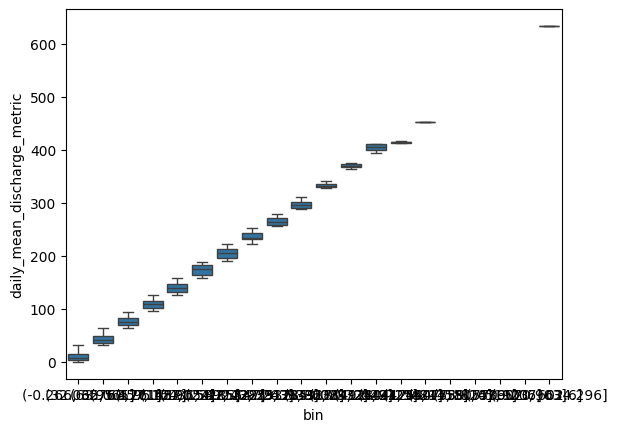

In [94]:
sns.boxplot(delaware_walton_df, x="bin", y="daily_mean_discharge_metric")

<Axes: xlabel='cumulative_freq_exceedence', ylabel='daily_mean_discharge_metric'>

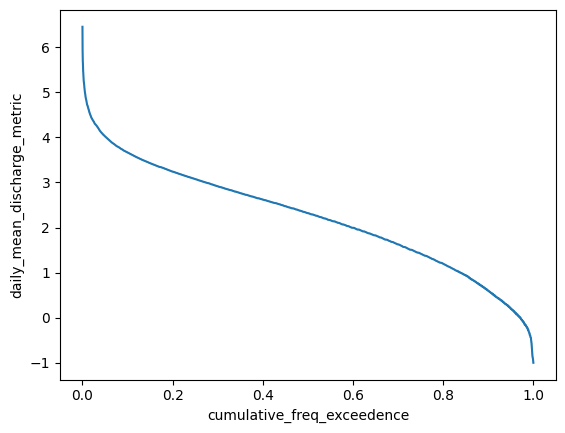

In [98]:
sns.lineplot(data=delaware_walton_df, y=np.log(delaware_walton_df["daily_mean_discharge_metric"]), x="cumulative_freq_exceedence")

<Axes: xlabel='day_of_year', ylabel='daily_mean_discharge_metric'>

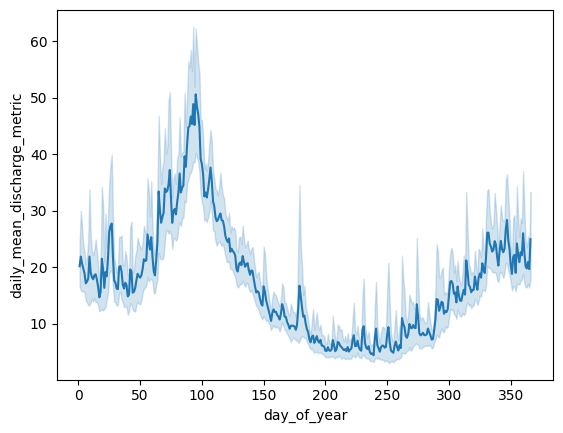

In [99]:
sns.lineplot(data=delaware_walton_df, x="day_of_year", y="daily_mean_discharge_metric")

<Axes: ylabel='Count'>

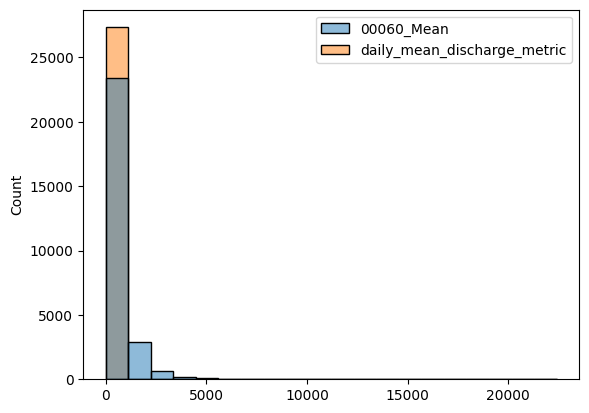

In [41]:
sns.histplot(data=delaware_walton_df, bins=20)

KeyboardInterrupt: 

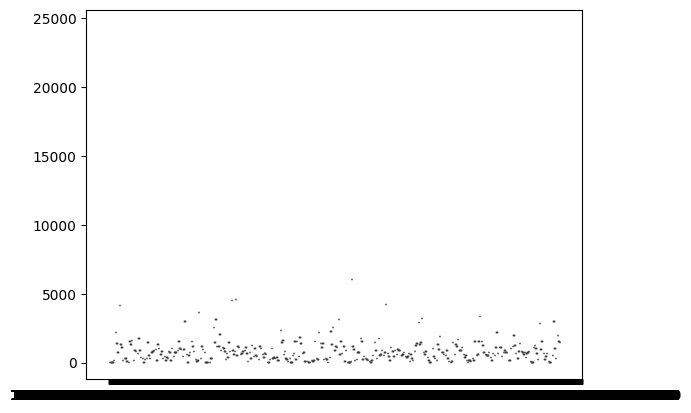

In [16]:
sns.boxplot(data=esopus_coldbrook_df, x=esopus_coldbrook_df.index, y="00060_Mean")